# 1 dropout原理
## 1.1 dropout目的
防止过拟合, 防止权重的参数规模过大, 过于描述训练数据的属性,而没有找出一般的规律来
## 1.2 dropout得原理
随机去掉一些权重
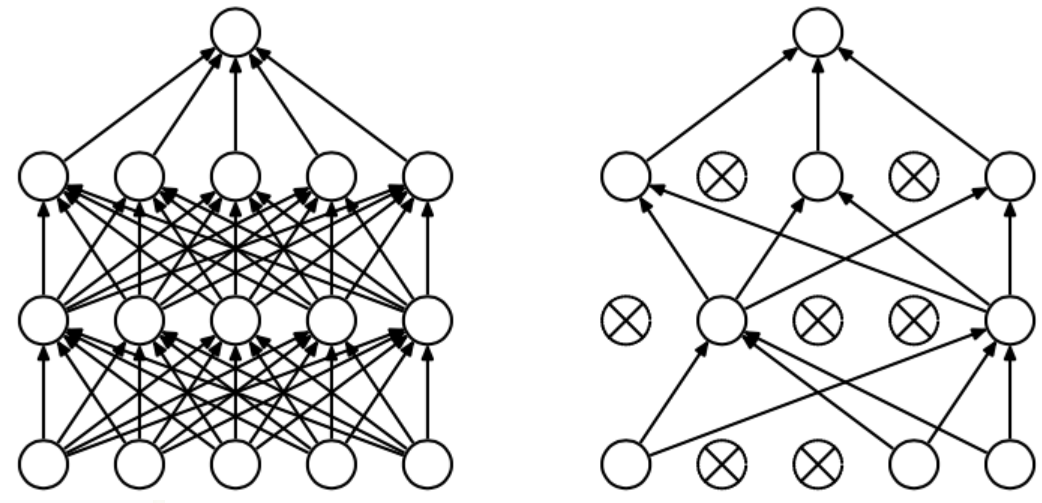

#2 数据的标准化
## 2.1 标准化常见的方法
常见的方法就是中心化和标准化，
- 中心化相当于修正数据的中心位置，就是在每个特征维度上减去对应的均值，最后得到 0 均值的特征。
- 标准化在数据变成 0 均值之后，为了使得不同的特征维度有着相同的规模，可以除以标准差近似为一个标准正态分布，也可以依据最大值和最小值将其转化为 -1 ~ 1 之间，
- 下面是一个简单的图示
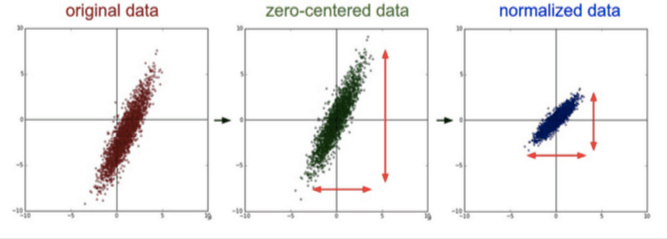

## 2.2 神经网络的批量标准化
就是对于每一层网络的输出，对其做一个归一化，使其服从标准的正态分布，这样后一层网络的输入也是一个标准的正态分布，所以能够比较好的进行训练，加快收敛速度
batch normalization 的实现，对于给定的一个 batch 的数据 $B = \{x_1, x_2, \cdots, x_m\}$算法的公式如下

$$
\mu_B = \frac{1}{m} \sum_{i=1}^m x_i
$$
$$
\sigma^2_B = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2
$$
$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}
$$
$$
y_i = \gamma \hat{x}_i + \beta
$$


第一行和第二行是计算出一个 batch 中数据的均值和方差，接着使用第三个公式对 batch 中的每个数据点做标准化， 𝜖  是为了计算稳定引入的一个小的常数，通常取  10−5 ，最后利用权重修正得到最后的输出结果。

### 2.2.1 注意事项
测试的时候数据量小，所以测试的时候不能用测试的数据集去算均值和方差，而是用训练的时候算出的移动平均均值和方差去代替。

# 3 pytorch的代码实现

In [3]:
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

## 3.1 测试训练数据

In [4]:
N_SAMPLES = 20
N_HIDDEN = 300

In [5]:
# training data
x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)
y = x + 0.3*torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))
x, y = Variable(x), Variable(y)

# test data
test_x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)
test_y = test_x + 0.3*torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))
with torch.no_grad():
    test_x, test_y = Variable(test_x), Variable(test_y)

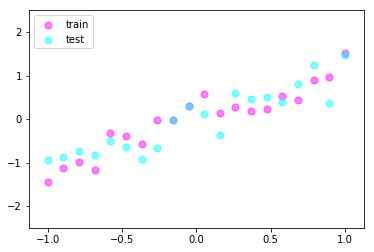

In [6]:
# show data
plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.5, label='train')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.5, label='test')
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

## 3.2 定义网络模型

In [8]:
## 全连接网络
net_overfitting = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)

In [9]:
## dropout网络
net_dropped = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.Dropout(0.5),  # drop 50% of the neuron
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.Dropout(0.5),  # drop 50% of the neuron
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)

### 3.2.1 查看两种网络结构
net architecture

In [10]:
print(net_overfitting)  
print(net_dropped)

Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): Dropout(p=0.5)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=300, bias=True)
  (4): Dropout(p=0.5)
  (5): ReLU()
  (6): Linear(in_features=300, out_features=1, bias=True)
)


### 3.2.2 定义优化算法和损失函数
- 损失函数:均方损失函数
    $$\text{loss}(\mathbf{x}_i, \mathbf{y}_i) = (\mathbf{x}_i - \mathbf{y}_i)^2$$

#### 3.2.2.1 优化算法
优化算法比对
- GD:
    有鞍点的缺陷
- SGD: 在鞍点附近收敛较慢,容易震荡
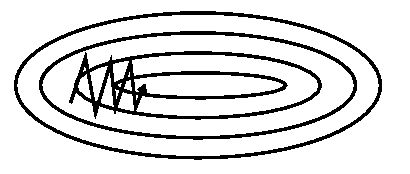




#### 3.2.2.2 adam优化算法
- Momentum算法
    - SGD 在遇到沟壑时容易陷入震荡。为此，可以为其引入动量 Momentum，加速 SGD 在正确方向的下降并抑制震荡。
- Adagrad
    - 以相同的学习率去更新的各个分量。而深度学习模型中往往涉及大量的参数，不同参数的更新频率往往有所区别。
    - 对于更新不频繁的参数,希望单次步长更大，多学习一些知识；
    - 对于更新频繁的参数，我们则希望步长较小，使得学习到的参数更稳定，不至于被单个样本影响太多。其引入了二阶动量.
- RMSprop
    - 在 Adagrad 中，是单调递增的，使得学习率逐渐递减至 0，可能导致训练过程提前结束。
为了改进这一缺点，可以考虑在计算二阶动量时不累积全部历史梯度，而只关注最近某一时间窗口内的下降梯度

- Adam
    - 可以认为是 RMSprop 和 Momentum 的结合。
    - 和 RMSprop 对二阶动量使用指数移动平均类似，Adam 中对一阶动量也是用指数移动平均计算。

In [13]:
optimizer_ofit = torch.optim.Adam(net_overfitting.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(net_dropped.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
loss_f=loss_func

## 3.3 训练模型

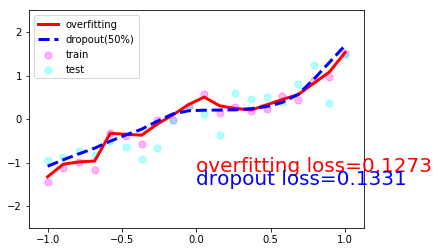

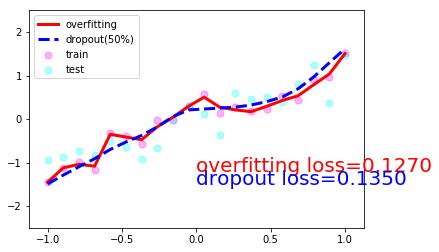

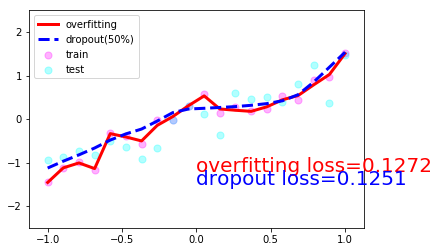

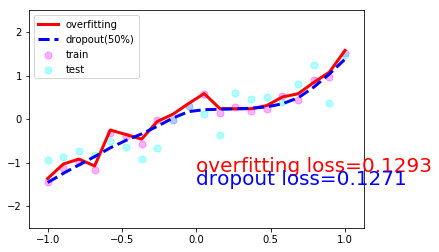

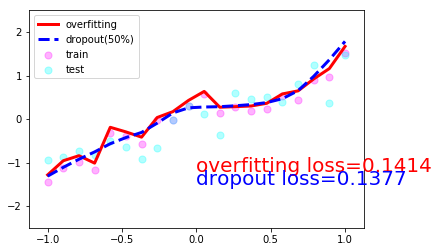

In [16]:
for t in range(500):
    # 前向传播求出预测的值
    pred_ofit = net_overfitting(x)
    pred_drop = net_dropped(x)
    # 计算损失函数在w0点的损失值
    loss_ofit = loss_func(pred_ofit, y)
    loss_drop = loss_func(pred_drop, y)
    
    # 网络参数的梯队值要先置为零
    # 对应 d_weights = [0] * n
    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    
    # 反向传播算法求各个网络参数的梯度值 
    loss_ofit.backward()
    loss_drop.backward()
    # 根据网络产生的梯队值更新现在的网络参数
    optimizer_ofit.step()
    optimizer_drop.step()
    
    # 每100
    if t % 100 == 0:        
        #model.eval()
        # dropout层,切换到测试阶段的计算方式
        # 不更新网络参数
        #使用PyTorch进行训练和测试时要把实例化的model指定train/eval，eval()时，框架会自动把BN和DropOut固定住，不会取平均，而是用训练好的值
        net_overfitting.eval()
        net_dropped.eval()

        # plotting
        plt.cla()
        test_pred_ofit = net_overfitting(test_x)
        test_pred_drop = net_dropped(test_x)
        ## 测试数据训练数据-画散点
        plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.3, label='test')
        ## 拟合数据画线
        plt.plot(test_x.data.numpy(), test_pred_ofit.data.numpy(), 'r-', lw=3, label='overfitting')
        plt.plot(test_x.data.numpy(), test_pred_drop.data.numpy(), 'b--', lw=3, label='dropout(50%)')
        ## 查看损失值的方法: loss_func(test_pred_ofit, test_y).item()
        plt.text(0, -1.2, 'overfitting loss=%.4f' % loss_func(test_pred_ofit, test_y).item(), fontdict={'size': 20, 'color':  'red'})
        plt.text(0, -1.5, 'dropout loss=%.4f' % loss_func(test_pred_drop, test_y).item(), fontdict={'size': 20, 'color': 'blue'})
        plt.legend(loc='upper left'); plt.ylim((-2.5, 2.5));plt.pause(0.1)

        # change back to train mode
        net_overfitting.train()
        net_dropped.train()
        plt.show()

# 4 结论
dropout拟合的曲线更加平滑, 测试集上面损失值更小.
防止了过拟合